# Relativistic Beaming
Through this notebook, we're going to look at how angular power distributions, spectra, and frame velocities interact to produce relativistically beamed distributions. Roughly speaking, when an emitter is travelling relativistically, the bulk of its power is directed in the direction of motion, even if the emitter was initially isotropic. We can understand this effect as the result of two relativistic effects: Aberration and Doppler shifting. 

In this notebook we're going to construct the relativistically beamed power distributions for arbitrary emitters with arbitrary spectra with arbitrary velocities. The resulting distributions may not have neat analytical forms which lend themselves to building intuition. However, the transformations of the paths and energies followed by individual emitted photons are easily described with special relativity.

To construct the beamed distributions, we're going to perform a simple Monte Carlo which produces a set of pseudo-photons which mimick the radiation from our emitter. The direction of these photons will be changed through relativistic aberration and their energies will be shifted by the relativistic doppler effect. The angular distributions will be constructed by performing simple histograms of these photons over angles.

We'll put this together piece by piece with a pair of complete examples at the end. Let's begin!

### Imports
Let's import matplotlib, numpy and packages for the widgets.

In [1]:
%matplotlib notebook

In [2]:
from ipywidgets import interact, interactive,  fixed
from IPython.display import clear_output, display, HTML

In [3]:
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

### Get Angles

To start, we'll have to get a set of the angles of some photons obeying some angular distribution. I've defined a Larmor and a uniform distribution here, but feel free to play around and add your own! Throughout this notebook, we're going to avoid physical units, so these function just return quantites proportional to the power at each angle.

In [4]:
def Larmor(T, P):
    '''
    Produce a Larmor distribution due to a charge accelerating along the pole
    
    Inputs:
        T: an [N] numpy array containing the polar angles for a N vectors
        P: an [N] numpy array containing the azimuthal angles for a N vectors
        
    Outputs:
        Powers: an [N] numpy array containing the powers for N vectors
    '''
    return(np.sin(T)**2)

In [5]:
def Uniform(T,P):
    '''
    Produce a Uniform (isotropic) distribution.
    
    Inputs:
        T: an [N] numpy array containing the polar angles for a N vectors
        P: an [N] numpy array containing the azimuthal angles for a N vectors
        
    Outputs:
        Powers: an [N] numpy array containing the powers for N vectors
    '''
    return(np.ones_like(T))

In [6]:
def getAngles(P,num):
    '''
    
    Produce a list of angles which obey a given power distribution.
    The angles are 'Theta', the polar angle, and 'Phi', the azimuthal angle.
    
   
    Inputs:
        P: A function describing the angular power distribution.
        P should accept two arguments:
            'Theta' an [N] numpy array containing the polar angle for each vector
            'Phi', an [N] numpy array containing the azimuthal angles for each vector
        P should return an [N] numpy array describing the power associated with each direction.
        P should be defined such that its maximum over angles is 1.
        
        num: An integer describing the number of angular pairs to find.
        
    Outputs:
        angles: A [num, 2] numpy array containing the list of angles
    
    '''
    
    goodAngles = []

    # Find a set of angles through a simple acceptance / rejection scheme
    while len(goodAngles) < num:
        
        # Set a limit on the number of new         angles to consider at a time (1 million)
        nNewAngles = min(num - len(goodAngles), 1000000)
        
        # Choose a set of angles which are randomly chosen from a unit sphere
        newProposedAngles = np.random.rand(nNewAngles, 2)
        newProposedAngles[:,0] = np.arccos(2 * newProposedAngles[:,0] - 1)
        newProposedAngles[:,1] = 2 * np.pi * newProposedAngles[:,1] - np.pi
        
        # Find the Power for each vector
        Powers = P(newProposedAngles[:,0], newProposedAngles[:,1])
        
        # Choose a random value between 0 and 1 corresponding to each vector
        acceptanceValues = np.random.rand(nNewAngles)
        
        # Accept a vector if its Power is greater than the random number
        for i in range(nNewAngles):
            if Powers[i] > acceptanceValues[i]:
                goodAngles.append(newProposedAngles[i,:])

    return(np.asarray(goodAngles))


### Construct a histogram
We'll display power distributions by tracing out the paths of many pseudo-photons and binning those paths into angular bins. Let's construct a function for producing and displaying this histogram.

In [7]:
def ConstructPowerHistogram(Angles,nTbins=40, nPbins=30, weights=None):
    '''
    
    Produce a 2D histogram and plot it in 3D.
    
   
    Inputs:
        Angles: A [num, 2] numpy array containing a list of Theta and Phi to be histogrammed.
        nTbins: An integer describing the number of bins to construct over polar angles.
        nPbins: An integer describing the number of bins to construct over azimuthal angles.
        weights: A [num] numpy array containing a list of weights to associate with each
            pair of angles. If weights=None, each pair will have the same weight.
        
    Outputs:
        A matplotlib figure will be displayed.

    '''  
    
    # Set up the figure and add a set of 3d axes to it.
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_axes([0,0,1,1], projection='3d')

    # Define the bin edges for the histogram. These will be linearly spaced over the azimuthal
    #     angle and will be linearly spaced in cos(theta)
    Tedges = np.arccos(np.linspace(1,-1, num=nTbins + 1))
    Pedges = np.linspace(-np.pi, np.pi, num = nPbins + 1)

    # Construct the histogram and find the centers of each histogram bin.
    hist, edges = np.histogramdd(Angles, bins=(Tedges,Pedges), weights=weights)
    edgecenters = [[0.5 * (edge[i+1] + edge[i]) for i in range(len(edge[:-1]))] for edge in edges]

    T = edgecenters[0]
    P = edgecenters[1]

    # Construct a mesh grid over Theta and Phi
    T, P = np.meshgrid(T, P)

    # Find the unit vector in cartesian coordinates which correspond to each histogram bin
    xHist = np.sin(T) * np.cos(P)
    yHist = np.sin(T) * np.sin(P)
    zHist = np.cos(T)

    # Find the vector (magnitude times unit vector) corresponding to each histogram bin
    XHist = np.transpose(hist) * xHist
    YHist = np.transpose(hist) * yHist
    ZHist = np.transpose(hist) * zHist

    # Plot the 3D surface
    surf = ax.plot_surface(XHist, YHist, ZHist, linewidth=0)

    # Set the limits of the plot so that the entire surface is included
    lims = (-np.max(hist),np.max(hist))
    ax.set_xlim(*lims)
    ax.set_ylim(*lims)
    ax.set_zlim(*lims)

    plt.show()


### Construct the power distribution in the emitter frame
Let's start out in the emitter's frame. If our radiation is due to an accelerating electron, this is the frame where that electron is instantaneously at rest. Let's confirm that the power distribution looks the way we'd like. We'll do this by constructing a histogram describing the number of our psuedo-photons which land in each angular bin.

We'll place the pole of our histograms along the z-axis at all times, which may lead to issues if your power distribution is doing something interesting there.

In [8]:
# Let's assume a Larmor distribution and produce 1 Million psuedo-photons This may take a couple seconds.
InitialAngles = getAngles(Larmor, 1000000)

<IPython.core.display.Javascript object>


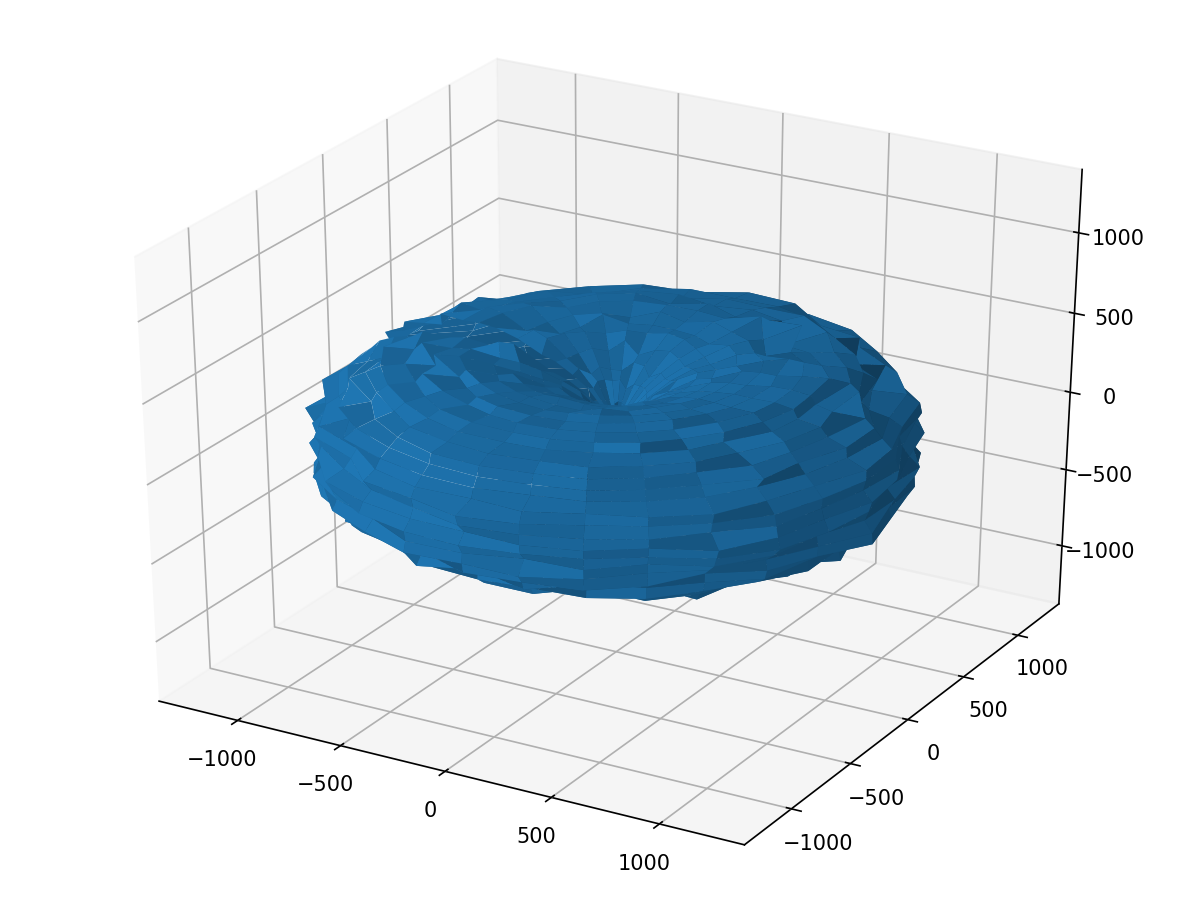

In [9]:
ConstructPowerHistogram(InitialAngles)

### Relativistic Aberration
Let's add our first beaming effect: Relativistic Aberration. Let's imagine we're in the emitter's frame and we throw a photon directly upwards. If we switch to an observer's frame, where the emitter is travelling to the right with some velocity, then the path traced out by the photon will be towards the upper-right. As the emitter's speed approaches the speed of light, the angle between the path followed by the emitter and the path followed by the photon shrinks and therefore the power emitted by the emitter becomes increasingly focused in its direction of motion.

To determine how angles in the emitter's frame and the observer's frame are related, we can follow Rybicki and Lightman 4.1.3. We can use the usual Lorentz transformations to write out the components of an arbitrary velocity which are parallel and perpendicular to the direction of motion of the emitter. We'll use primed variables to refer to the emitter's frame and unprimed to refer to the observer's frame:

$$
\begin{aligned}
u_\parallel &= \frac{u'_\parallel + v}{1 + v u'_\parallel / c^{2}}\\
u_\perp &= \frac{u'_\perp}{\gamma(1 + v u'_\parallel / c^{2})}\\
\tan \theta &= \frac{u'_\perp}{\gamma (u'_\parallel + v)}\\
\tan \theta &= \frac{u' \sin \theta'}{\gamma (u' \cos \theta' + v)}\\
\cos \theta &= \frac{u_\parallel}{u} = \frac{\frac{u'}{c}\cos \theta'  + \frac{v}{c}}{\sqrt{\frac{u^{\prime 2}}{c^2} (1 - \frac{v^2}{c^2}) + \frac{v^2}{c^2} + \frac{2 u' v \cos \theta'}{c^2} + \frac{v^2 u^{\prime 2} \cos^2 \theta'}{c^4}}}
\end{aligned}
$$

Since the velocities we're interested in are photon velocities, we can use $u = u' = c$.
$$
\begin{aligned}
\tan \theta &= \frac{\sin \theta'}{\gamma ( \cos \theta' + \frac{v}{c})}\\
\cos \theta &= \frac{\cos \theta'  + \frac{v}{c}}{1 + \frac{v}{c} \cos \theta'}
\end{aligned}
$$

In the emitter's frame, $\theta' = \pi / 2$ marks out a hemisphere. In the observer's frame, that angle is smaller with $\sin \theta = \gamma^{-1}$.

### Moving to an observer frame
Let's switch frames to an observer frame. In this frame, the emitter is travelling with speed $\beta$ in the x direction. Let's plot out the instantaneous power distribution in this frame.

This is done is a somewhat roundabout manner with a several coordinate transformations. We begin with spherical coordinates with the polar axis along the $z$ axis. We convert these to Cartesian, then rotate those Cartesian so that the $z'$ axis is aligned with the direction of motion. We calculate the new polar angle due to aberration in these coordinates. We then switch back to Cartesian coordinates and undo our rotation. Finally, we return to our original spherical coordinates with the polar axis aligned with the original $z$ axis.

<IPython.core.display.Javascript object>


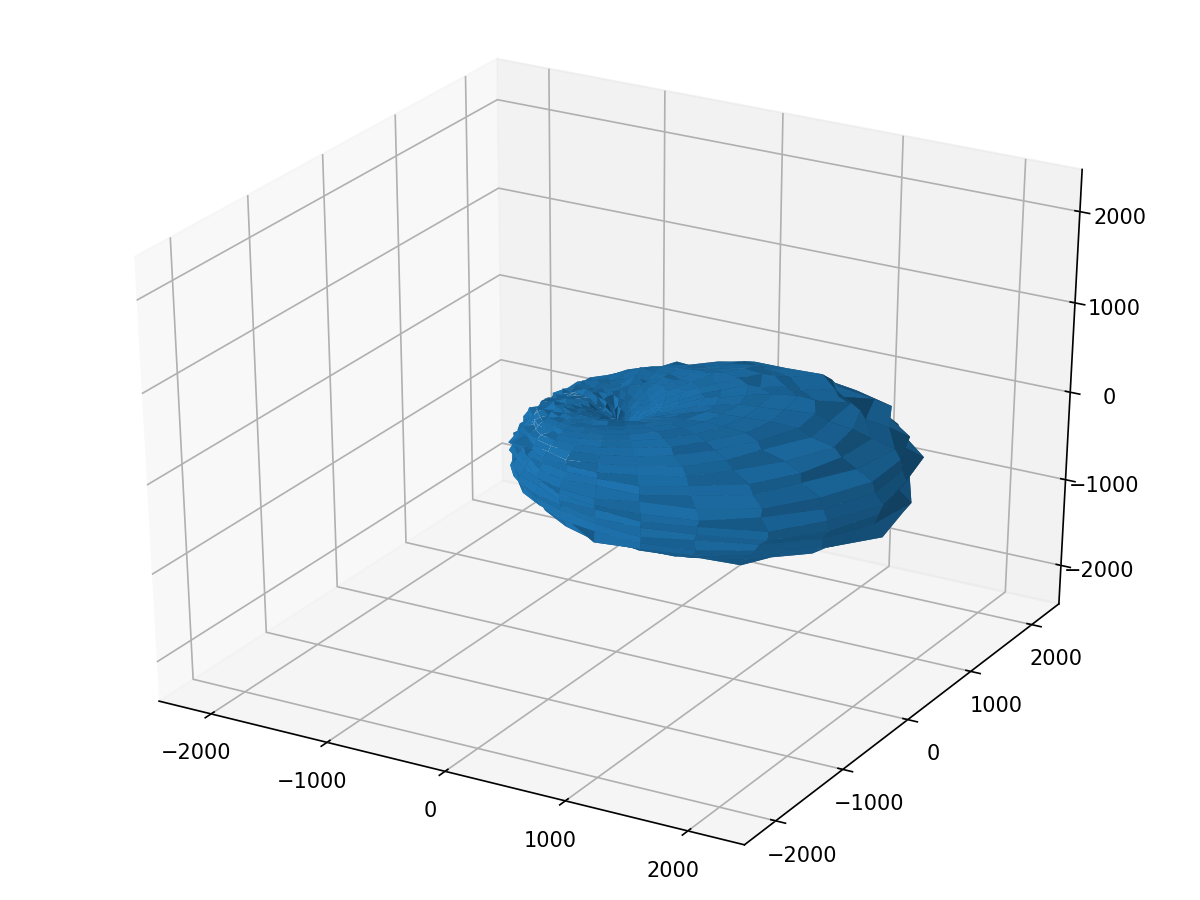

In [10]:
def GetAberrationAngles(Angles, Beta, BetaTheta, BetaPhi):
    '''
    
    Takes a list of angles describing directions of motion in the emitter-frame and the
    emitter's velocity and Lorentz-transforms those directions of motion into the observer's
    frame
    
   
    Inputs:
        Angles: A [num, 2] numpy array containing a list of Theta and Phi in the emitter's
            frame
        Beta: A float describing the speed (Beta = v/c) of the emitter in the observer's frame
        BetaTheta: A float describing the polar angle of the emitter's velocity in the
            observer's frame
        BetaPhi: A float describing the azimuthal angle of the emitter's velocity in the
            observer's frame
        
    Outputs:
        AberrationAngles: A [num, 2] numpy array containing the list of Theta and Phi in the
            observer's frame after performing the Lorentz transformation

    '''  

    ## Get the cartesian coordinates for the emitter-frame rays
    xRa = np.sin(Angles[:,0]) * np.cos(Angles[:,1])
    yRa = np.sin(Angles[:,0]) * np.sin(Angles[:,1])
    zRa = np.cos(Angles[:,0])
    
    ## Perform a rotation by the given BetaTheta and BetaPhi so that the direction of motion is aligned with the z axis
    cT = np.cos(-BetaTheta)
    sT = np.sin(-BetaTheta)
    cP = np.cos(-BetaPhi)
    sP = np.sin(-BetaPhi)
    
    ## Rotate by -BetaPhi about the Z axis, then -BetaTheta about the y axis
    
    xRot =  cT * cP * xRa - cT * sP * yRa + sT * zRa
    yRot =       sP * xRa +      cP * yRa
    zRot = -sT * cP * xRa + sT * sP * yRa + cT * zRa      

    ## Turn these into spherical coordinates such that theta = 0 is aligned with the direction of motion (assumed x)
    Theta = np.arccos(zRot)
    Phi = np.arctan2(yRot, xRot)

    ## Find the new polar angle after with aberration
    ThetaRa = np.arccos((np.cos(Theta) + Beta)* (1 + Beta * np.cos(Theta))**(-1))

    ## Get the new cartesian coordinates

    xRotA = np.sin(ThetaRa) * np.cos(Phi)
    yRotA = np.sin(ThetaRa) * np.sin(Phi)
    zRotA = np.cos(ThetaRa)
    
    ## Invert the rotation (BetaTheta about the y axis, then BetaPhi about the z axis)

    xA =   cT * cP * xRotA + sP * yRotA - sT * cP * zRotA
    yA = - cT * sP * xRotA + cP * yRotA + sT * sP * zRotA
    zA =        sT * xRotA + cT * zRotA
        
    ## And switch back to polar with an axis aligned with the Z-axis

    ThetaRaA = np.arccos(zA)
    PhiRaA = np.arctan2(yA, xA)   

    ## Construct a nice new angle array from the new Theta and Phi
    AberrationAngles = np.empty((len(ThetaRa),2))
    AberrationAngles[:,0] = ThetaRaA
    AberrationAngles[:,1] = PhiRaA
    return(AberrationAngles)


## Let's look at a case where the emitter is travelling with v = 0.3 c in the x direction.
Beta = 0.3
AberrationAngles = GetAberrationAngles(InitialAngles, Beta,np.pi / 2, 0.0)
ConstructPowerHistogram(AberrationAngles)

### Doppler Shifts
The second beaming effect is the relativistic Doppler shift. For a given emission frequency, we will observe an increased frequency for photons emitted along the direction of motion and a reduced frequency for photons emitted in the opposite direction. The relation between the frequency in the emitter and observer frames are given by Rybicki and Lightman Eq 4.12:

$$
\omega' = \omega \gamma (1 - \frac{v}{c} \cos \theta )\\
\omega = \omega' \gamma (1 + \frac{v}{c} \cos \theta' )\\
$$
where $\omega$ is the observed frequency, $\omega'$ is the emitted frequency, and $\theta$ is the angle between the photon direction and the direction of motion of the emitter.

If we have a monochromatic source and can observe photons of any wavelength, then the power we observed will be shifted by a Doppler factor. Let's consider this case first. To do this, we'll construct a list containing the Doppler factor for each of our pseudo-photons, then use those Doppler factors to weight our histogram.

<IPython.core.display.Javascript object>


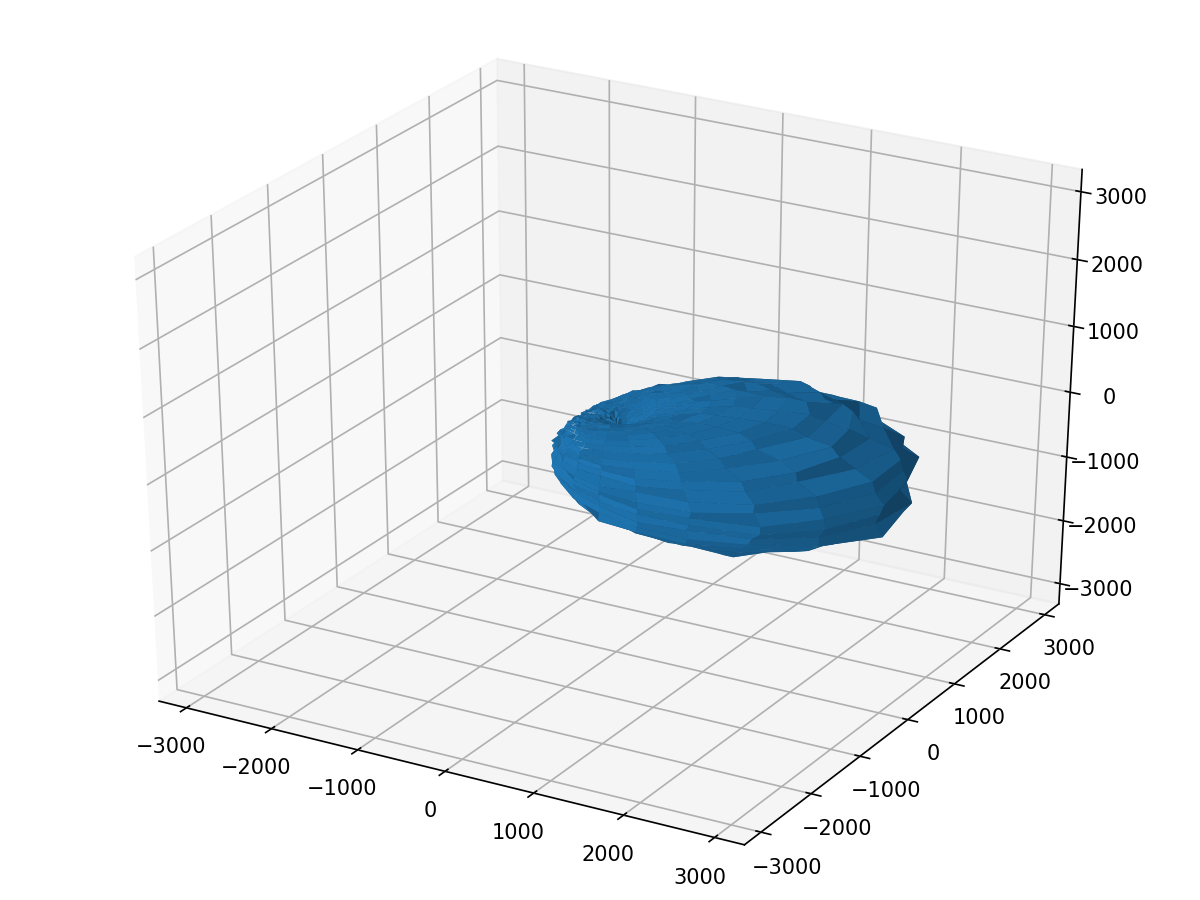

In [11]:
def GetDopplerFactors(Angles, Beta, BetaTheta, BetaPhi):
    '''
    
    Takes a list of angles describing directions of motion in the emitter-frame and the
    emitter's velocity and finds the corresponding Doppler factor (DF)
    If the emitted frequency is omega_emit and the observed frequency is omega_obs, then
    omega_emit = omega_obs * DF
    
   
    Inputs:
        Angles: A [num, 2] numpy array containing a list of Theta and Phi in the observer's
            frame
        Beta: A float describing the speed (Beta = v/c) of the emitter in the observer's frame
        BetaTheta: A float describing the polar angle of the emitter's velocity in the
            observer's frame
        BetaPhi: A float describing the azimuthal angle of the emitter's velocity in the
            observer's frame
        
    Outputs:
        DopplerFactors: A [num] numpy array containing list of Doppler Factors

    '''    

    # Find the angles between the direction of motion of the emitter and the given directions of motions
    cosThetaDf =  np.sin(Angles[:,0]) * np.cos(Angles[:,1]) * np.sin(BetaTheta) * np.cos(BetaPhi)
    cosThetaDf += np.sin(Angles[:,0]) * np.sin(Angles[:,1]) * np.sin(BetaTheta) * np.sin(BetaPhi)
    cosThetaDf += np.cos(Angles[:,0]) * np.cos(BetaTheta)
    
    ThetaDf = np.arccos(cosThetaDf)
    
    # Compute gamma and the Doppler Factor according to R&L 4.12
    gamma = (1 - Beta * Beta)**(-0.5)
    DopplerFactors = (gamma * (1 - Beta * np.cos(ThetaDf)))
    
    return(DopplerFactors)


# Let's check it out! This will give us the power distribution summed over all frequencies 
#    from a monochromatic source.

DopplerFactors = GetDopplerFactors(AberrationAngles, Beta,np.pi / 2, 0.0)
ConstructPowerHistogram(AberrationAngles, weights=1. / DopplerFactors)


### Doppler shifts at a fixed frequency
If we only observe a small band of frequencies, then we must account for the spectrum of the emitter.
Photons we observe along the direction of motion began at lower frequencies while those observed in the opposite direction began at higher frequencies. Accordingly, the power we observe will also depend number of photons emitted at higher and lower frequencies. If we know the spectrum of the emitter, we can write out the power at a fixed frequency using the Doppler shift relation
$$
\begin{aligned}
S_{\nu'} &= h \nu' f(\nu')\\
S_{\nu, \Omega} &= h \nu \gamma (1 - \frac{v}{c} \cos \theta ) f(\nu \gamma (1 - \frac{v}{c} \cos \theta ))\\
\end{aligned}
$$
This has a particularly nice form if we can associate a spectral index with the spectrum:
$$
\begin{aligned}
S_{\nu'} &\propto \nu^{\prime p}\\
S_{\nu, \Omega} &\propto \nu^p (\gamma (1 - \frac{v}{c} \cos \theta ))^{p}\\
\end{aligned}
$$
Along the direction of motion, the Doppler term will be less than unity. If $p$ is negative, this leads to another enhancement of the power in the direction of motion. However, if $p$ is positive, as in the Rayleigh-Jeans limit of the Blackbody spectrum where $p = 2$, this effect will actually *decrease* the power in the forward lobe.

Let's now look at these equations to produce the power at a fixed frequency taking into account relativistic aberration, Doppler shifts, and the spectrum of the emitter. To do this, we need to define a spectrum function and use that function to set the weights in our histogram.

I've provided two sample spectra: a power law and a blackbody. The power law only needs a defined spectral index, while the blackbody requires a temperature and the frequency we're observing at. This will yield the spectrum of a blackbody which is moving relativistically (a quickly-moving star for example).

In [12]:
def PowerLawSpectrum(DFs, p):
    '''
    Returns the power associated with a power law spectrum with spectral index p for photons with
        given Doppler shifts. The returned value will be relative to a photon with no doppler
        shift.
    
    Inputs:
        DFs: an [N] numpy array containing the Doppler Factors (as defined in 
            GetDopplerFactors)
        p: a float with the spectral index of the spectrum
        
    Outputs:
        Power: an [N] numpy array containing the relative power for each Doppler Factor
            relative those with DF = 1.
    '''
    return(np.power((DFs),p))

In [13]:
def BlackbodySpectrum(DFs, nu0, T):
    '''
    Returns the power associated with a Planck spectrum with temperature T for photons with
        given Doppler shifts, relative to the power observed at frequency nu0 (with no
        Doppler shift).
    
    Inputs:
        DFs: an [N] numpy array containing the Doppler Factors (as defined in 
            GetDopplerFactors)
        nu0: a float with our observation frequency. (Hz)
        T: a float with the temperature of our distribution (K)
        
    Outputs:
        Power: an [N] numpy array containing the power for each Doppler Factor relative those
            with DF = 1.
    '''
    
    h = 6.626e-27
    k = 1.381e-16
    expFactor0 = nu0 * h / (k * T)
    expFactor =  DFs * expFactor0
    return(DFs**3 * (np.exp(expFactor0) - 1) / (np.exp(expFactor) - 1))

<IPython.core.display.Javascript object>


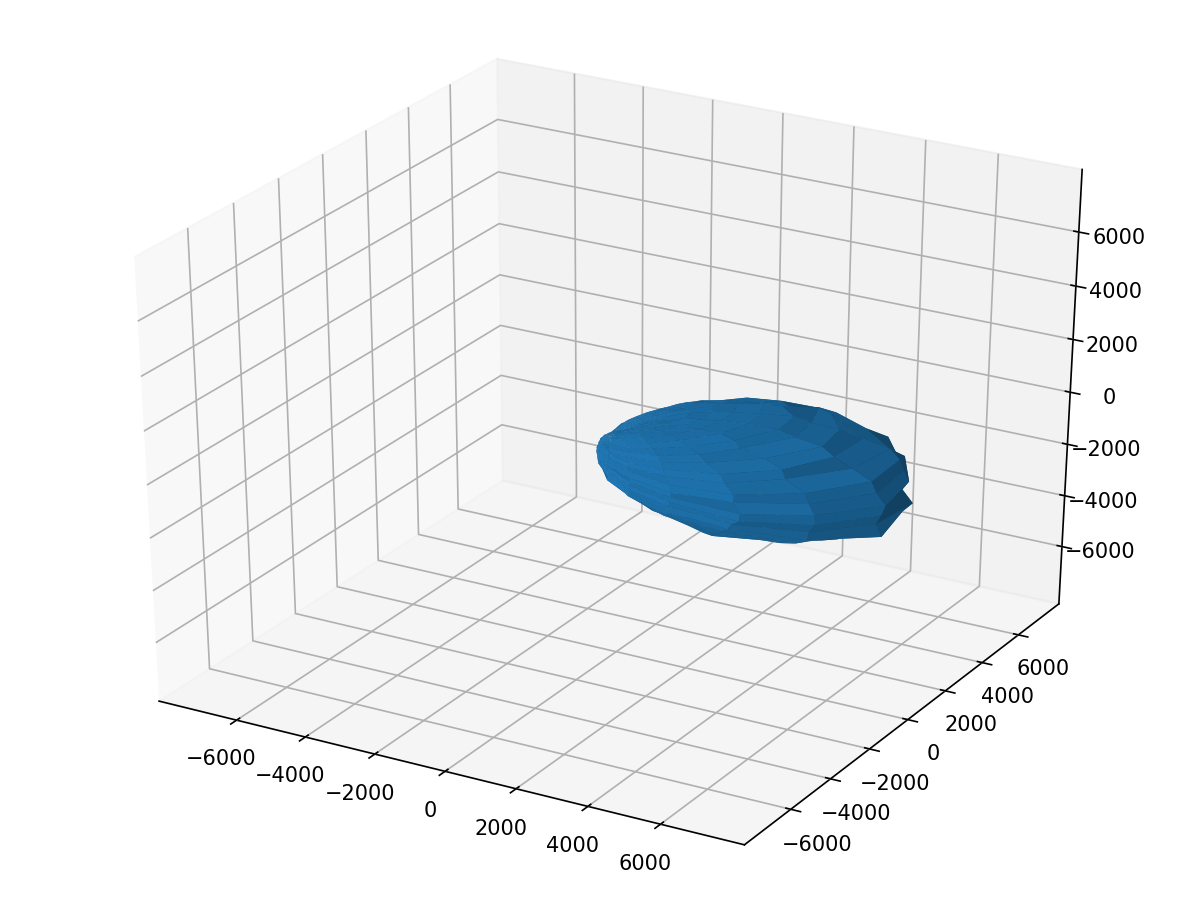

In [14]:
Powers = PowerLawSpectrum(DopplerFactors, -4)
ConstructPowerHistogram(AberrationAngles, weights=Powers)

### Putting it all together!

Let's put everything in one place for easy modification and evaluation!

In [15]:
## Let's choose our emitter-frame power distribution (Larmor or uniform or something you create!)
InitialAngles = getAngles(Larmor, 1000000)

## Let's make an interactive widget where we can change the direction and speed of the emitter
## and the shape of the power spectrum. This first example uses a power-law spectrum and a
## Larmor distribution.
## Choose Beta = v / c, the speed of the emitter in the observer's frame.
## Choose BetaTheta and BetaPhi for the direction of motion of the emitter:
##     For motion along the x-axis use BetaTheta = pi / 2, BetaPhi = 0.
##     For motion along the y-axis use BetaTheta = pi / 2, BetaPhi = pi / 2.
##     For motion along the z-axis, use BetaTheta = 0, BetaPhi = 0.
## Choose the spectral index p. Positive p has increasing power with increasing frequency.

@interact(Beta=(0,0.999999), BetaTheta=(0,np.pi), BetaPhi=(-np.pi, np.pi), p=(-10,10))
def interactiveBeaming(Beta, BetaTheta, BetaPhi, p):

    AberrationAngles = GetAberrationAngles(InitialAngles, Beta, BetaTheta, BetaPhi)

    DopplerFactors = GetDopplerFactors(AberrationAngles, Beta, BetaTheta, BetaPhi)

    Powers = PowerLawSpectrum(DopplerFactors, p)
    ConstructPowerHistogram(AberrationAngles, weights=Powers)
    


interactive(children=(FloatSlider(value=0.4999995, description='Beta', max=0.999999), FloatSlider(value=1.5707…

In [16]:
## This second example uses a blackbody spectrum which was emitted isotropically.
## Choose a temperature for the blackbody (T)
## Choose a temperature for the observed photons (Tobs = h nu_0 / k)
    
InitialAngles = getAngles(Uniform, 1000000)

@interact(Beta=(0,0.999999), BetaTheta=(0,np.pi), BetaPhi=(-np.pi, np.pi), T=(1,6000), Tobs=(1,6000))
def interactiveBeaming(Beta, BetaTheta, BetaPhi, T, Tobs):
    h = 6.626e-27
    k = 1.381e-16
    nu0 = k * Tobs / h
    
    AberrationAngles = GetAberrationAngles(InitialAngles, Beta, BetaTheta, BetaPhi)

    DopplerFactors = GetDopplerFactors(AberrationAngles, Beta, BetaTheta, BetaPhi)
    
    Powers = BlackbodySpectrum(DopplerFactors, nu0, T)
    ConstructPowerHistogram(AberrationAngles, weights=Powers)
    


interactive(children=(FloatSlider(value=0.4999995, description='Beta', max=0.999999), FloatSlider(value=1.5707…